In [2]:
#working through chapter 05 of Python Machine Learning
# available from PACKT Publishing

# This chapter will work through dimensionality reduction

In [3]:
# bring in a wine data set
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)



In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                   , test_size=0.3
                                                   , random_state=0
                                                   )
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [13]:
# extract eigenvectors and eigenvalues from the above matrices
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)



Eigenvalues 
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [7]:
# generate graphic for cumulative sum of explained variance
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in 
           sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(1,14), var_exp, alpha=0.5, align='center'
       , label = 'individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid'
        , label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

NameError: name 'eigen_vals' is not defined

In [21]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [35]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis]
          ,eigen_pairs[1][1][:, np.newaxis]
          ))
print('Matrix W:', w)

('Matrix W:', array([[ 0.14669811,  0.50417079],
       [-0.24224554,  0.24216889],
       [-0.02993442,  0.28698484],
       [-0.25519002, -0.06468718],
       [ 0.12079772,  0.22995385],
       [ 0.38934455,  0.09363991],
       [ 0.42326486,  0.01088622],
       [-0.30634956,  0.01870216],
       [ 0.30572219,  0.03040352],
       [-0.09869191,  0.54527081],
       [ 0.30032535, -0.27924322],
       [ 0.36821154, -0.174365  ],
       [ 0.29259713,  0.36315461]]))


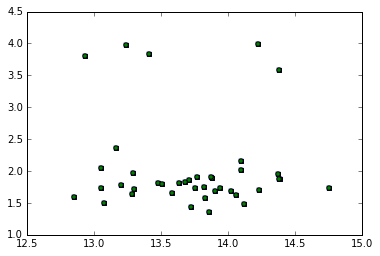

In [45]:
# we now have a projection matrix from our top-two eigenvectors
# we can now transform a 2-D sample vector with a dot product

X_train_pca = X_train_std[0].dot(w)

# visualize
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l,c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train[y_train==1, 0]
               , X_train[y_train==1, 1]
               , c=c, label=l, marker=m)
    

In [44]:
X_train[y_train==1, 0]

array([ 13.71,  13.3 ,  13.16,  13.24,  14.1 ,  13.05,  13.94,  14.1 ,
        14.75,  12.85,  14.06,  13.63,  13.82,  14.37,  14.39,  13.75,
        14.38,  14.23,  14.38,  14.12,  13.48,  13.29,  13.41,  13.2 ,
        13.88,  13.83,  13.07,  13.77,  13.51,  13.87,  13.58,  13.68,
        14.02,  13.05,  14.22,  13.72,  13.28,  12.93,  13.86,  13.9 ])

In [40]:
# implement a kernel PCA
# using the radial basis function kernel

from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation
    
    Parameters
    
    X: (numpy ndarray), shape = {n_samples, n_features}
    
    gamma: float
        Tuning parameter of the RBF kernel
    
    n_components: int
        Number of principal components to return
        
    Returns
    
    X_pc: (numpy ndarray), shape = {n_samples, k_features}
        Projected dataset
    
    """
    
    # calculate pairwise squared Euclidean distances
    # in the MXN dimensional dataset
    sq_dists = pdist(X, 'sqeuclidean')
    
    # convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    
    # compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    # center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # obtain eigenpairs from the centered kernel matrix
    eigvals, eigvecs = eigh(K)
    
    # collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i]
                           for i in range(1, n_components + 1)
                           ))
    
    return X_pc

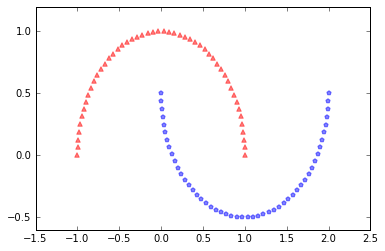

In [20]:
# let's implement the RBF PCA approach to a dataset
# this one contains info on half-moon shapes - should be 
# an ideal application for RBFs

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1]
           , color='red', marker='^', alpha=0.5
           )
plt.scatter(X[y==1, 0], X[y==1, 1]
           , color='blue', marker='p', alpha=0.5
           )

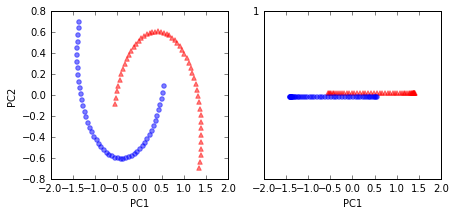

In [36]:
# in order to make these points linearly-separable, we will
# need to project them into a different-dimensional space 

from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
# plot this transformation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1]
             , color='red', marker='^', alpha=0.5
             )
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1]
             , color='blue', marker='o', alpha=0.5
             )
ax[1].scatter(X_spca[y==0,0], np.zeros((50,1))+0.02
              , color='red', marker='^', alpha=0.5
             )
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02
              , color='blue', marker='o', alpha=0.5
             )
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([1])
ax[1].set_xlabel('PC1')
# we can see that the out-of-the-box PCA will not work

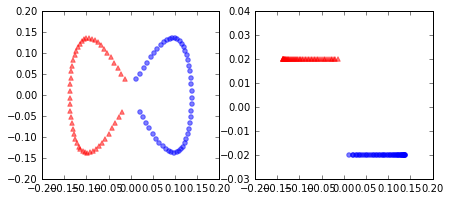

In [46]:
from matplotlib.ticker import FormatStrFormatter
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1]
             , color='red', marker='^', alpha=0.5
             )
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1]
             , color='blue', marker='o', alpha=0.5
             )
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02
             , color='red', marker='^', alpha=0.5
             )
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02
             , color='blue', marker='o', alpha=0.5
             )


In [48]:
# modify the rbf_kernel_pca function so that it also
# returns the eigenvectors of the kernel matrix

from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation
    
    Parameters
    
    X: (numpy ndarray), shape = {n_samples, n_features}
    
    gamma: float
        Tuning parameter of the RBF kernel
    
    n_components: int
        Number of principal components to return
        
    Returns
    
    X_pc: (numpy ndarray), shape = {n_samples, k_features}
        Projected dataset
   
    lambdas: list
        Eigenvalues
        
    """
    
    # calculate pairwise squared Euclidean distances
    # in the MXN dimensional dataset
    sq_dists = pdist(X, 'sqeuclidean')
    
    # convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    
    # compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    # center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # obtain eigenpairs from the centered kernel matrix
    eigvals, eigvecs = eigh(K)
    
    # collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i]
                           for i in range(1, n_components + 1)
                           ))
    lambdas = [eigvals[-i] for i in range(1,n_components + 1)]
    
    return alphas, lambdas

In [51]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [57]:
x_new = X[25]
print x_new

x_proj = alphas[25]
print x_proj

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum(
                (x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
print x_reproj


[ 1.8713187   0.00928245]
[ 0.07877284]
[ 0.07877284]


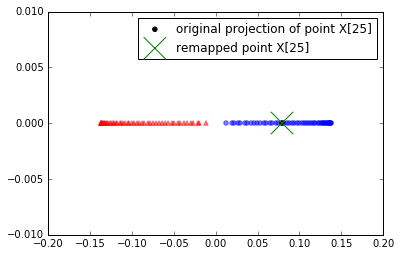

In [62]:
# let's visualize this - we have essentially remapped
# one point to where it was mapped initially - this 
# was the goal

plt.scatter(alphas[y==0, 0], np.zeros((50))
           , color='red', marker='^', alpha=0.5
           )
plt.scatter(alphas[y==1, 0], np.zeros((50))
           , color='blue', marker='o', alpha=0.5
           )
plt.scatter(X_proj, 0, color='black'
           , label='original projection of point X[25]'
           )
plt.scatter(x_reproj, 0, color='green'
           , label='remapped point X[25]'
           , marker='x', s=500
           )
plt.legend(scatterpoints=1)


